# Fleet Clustering

### Tim Hochberg, 2019-01-16

## Blog Support Edition

We cluster vessel using HDBSCAN and a custom metric to derive fleets
that are related in the sense that they spend a lot of time in the same
location while at sea.

## See Also

* Other notebooks in https://github.com/GlobalFishingWatch/fleet-clustering for 
examples of clustering Squid Jiggers, etc.
* This workspace that Nate put together: https://globalfishingwatch.org/map/workspace/udw-v2-85ff8c4f-fbfe-4126-b067-4d94cdd2b737

In [2]:
from __future__ import print_function
from __future__ import division
from collections import Counter, OrderedDict
import datetime as dt
import hdbscan
import logging
import matplotlib.pyplot as plt
import matplotlib.animation as mpl_animation
import numpy as np
import pandas as pd
from skimage import color
from IPython.display import HTML
from fleet_clustering import bq
from fleet_clustering import filters
from fleet_clustering import distances
from fleet_clustering import animation

## Load AIS Clustering Data

Load the AIS data that we use for clustering. Note that it onlyu includes vessels away
from shores so as to exclude clustering on ports

In [3]:
all_by_date = bq.load_ais_by_date('drifting_longlines', dt.date(2016, 1, 1), dt.date(2018, 12, 31),
                                 fishing_only=False, min_km_from_shore=0)    
pruned_by_date = {k : filters.remove_near_shore(10,
                            filters.remove_chinese_coast(v)) for (k, v) in all_by_date.items()}
valid_ssvid = sorted(filters.find_valid_ssvid(pruned_by_date))

2016-01-01


//anaconda/envs/ml2/lib/python2.7/site-packages/google/auth/_default.py:66: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK. We recommend that most server applications use service accounts instead. If your application continues to use end user credentials from Cloud SDK, you might receive a "quota exceeded" or "API not enabled" error. For more information about service accounts, see https://cloud.google.com/docs/authentication/.
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


2016-07-03
2017-01-03
2017-07-06
2018-01-06
2018-07-09


# Simple, Daily Clustering

## Create Distance Metrics

Create an array of distance metrics. The details are still evolving, but in general
we want to deal with two things.  Days on which a boat is missing and days where the
boat is away from the fleet.

* Distances to/from a boat on days when it is missing are represented by $\infty$ in 
  the distance matrix. HDBSCAN ignores these values.
* Only the closest N days are kept for each boat pair, allowing boats to leave the fleet
  for up to half the year without penalty.
  
In addition, distances have a floor of 1 km to prevent overclustering when boats tie up
up together, etc.

In [36]:
dists_by_date = {}

In [38]:
for i in [1, 7]:
    start_date = end_date = '201701{:02d}'.format(i)
    key = start_date + '_daily'
    if key in dists_by_date:
        continue
    print("computing distance for", start_date, end_date)
    subset_by_date = {k : v for (k, v) in pruned_by_date.items() if start_date <= k <= end_date}
    C = distances.create_composite_lonlat_array(subset_by_date, valid_ssvid)
    dists = distances.compute_distances_RMS(C)
    dists_by_date[key] = dists

computing distance for 20170101 20170101
computing distance for 20170107 20170107


## Fit the Clusterer

This is pretty straightforward -- all the complicated stuff is
embedded in the matrix computations. Fleet size can be tweaked
using `min_cluster_size` and `min_sample_size`.

In [39]:
raw_clusterers = {}
for key in ['20170101_daily', '20170107_daily']:
    clusterer = hdbscan.HDBSCAN(metric='precomputed', 
                                min_cluster_size=9,
                               )
    dists = dists_by_date[key]
    clusterer.fit(dists)
    raw_clusterers[key] = clusterer

## Set up Fleets

Set up the fleets for viewing.

In [40]:
def to_rgb(string):
    string = string.strip('#')
    r = string[:2]
    g = string[2:4]
    b = string[4:]
    return [int(x, 16) / 225.0 for x in (r, g, b)]


def find_labels(dists):
    clusterer = hdbscan.HDBSCAN(metric='precomputed', 
                                min_cluster_size=9).fit(dists)
    
    all_fleet_ssvid_set = set([s for (s, f) in zip(valid_ssvid, clusterer.labels_) if f >= 0])
    valid_ssvid_set = set(valid_ssvid)

    valid_ssvid_set = set(valid_ssvid)
    joint_ssvid = valid_ssvid
    labels = list(clusterer.labels_) 

    # Remove vessels that have no connection to other vessels
    for i, ssvid in enumerate(valid_ssvid):
        connections = (~np.isinf(dists[i])).sum()
        if connections == 0:
            labels[i] = -1
            
    return joint_ssvid, labels


def create_fleet_mapping(labels, include_carriers=False):
    counts = []
    skip = []
    for i in range(max(labels) + 1):
        if i in skip:
            counts.append(0)
        else:
            counts.append((np.array(labels) == i).sum())

    fleet_ids = [x for x in np.argsort(counts)[::-1] if counts[x] > 0]
    fleet_ids_without_carriers = [x for x in fleet_ids if x != max(labels)]

    fleets = OrderedDict()
    n_hues = int(np.ceil(len(fleet_ids) / 4.0))
    used = set()
    for i, fid in enumerate(fleet_ids_without_carriers):
        b = (i // (2 * n_hues)) % 2
        c = (i // 2)% n_hues
        d = i  % 2
        symbol = 'H^'[d]
        assert (b, c, d) not in used, (i, b, c, d)
        used.add((b, c, d))
        sat = 1
        val = 1
        raw_hue = c / float(n_hues)
        # We remap the raw hue in order to avoid the 60 degree segment around blue
        hue = 5. / 6. * raw_hue
        if hue > 7. / 12.:
            hue += 1. / 6.
        assert 0 <= hue < 1, hue
        [[clr]] = color.hsv2rgb([[(hue, sat, val)]])
        fg = [[0.1511111111111111, 0.2, 0.3333333333333333], clr][b]
        bg = [clr, [0.1511111111111111, 0.2, 0.3333333333333333]][b]
        w = [1, 2][b]
        sz = [9, 7][b]
        fleets[fid] = (symbol, tuple(fg), tuple(bg), sz, w,  str(i + 1))
    if include_carriers:
        fleets[max(labels)] = ('1', 'k', 'k', 8, 2, 'Carrier Vessel')
    print(len(set([x for x in fleets if x != -1])), "fleets")
    return fleets
    
    
def iou(a, b):
    a = set(a)
    b = set(b)
    return len(a & b) / len(a | b)

def best_match(a, bs):
    ious = [iou(a, b) for b in bs]
    i = np.argmax(ious)
    if ious[i] == 0:
        return None
    return i

    
def adapt_fleet_mapping(base_fleets, base_ssvid, base_labels, new_ssivd, new_labels):
    new_labels = np.array(new_labels)
    ssvid_base = []
    base_fleet_ids = sorted(base_fleets)
    for fid in base_fleet_ids:
        mask = (base_labels == fid)
        ssvid_base.append(np.array(base_ssvid)[mask])

    ssvid_new = []
    new_fleet_ids = sorted(set([x for x in new_labels if x != -1]))
    for fid in new_fleet_ids:
        mask = (new_labels == fid)
        ssvid_new.append(np.array(new_ssivd)[mask])

    rev_mapping = {}
    for fid, ssvid_list in zip(new_fleet_ids, ssvid_new):
        i = best_match(ssvid_list, ssvid_base)
        if i is None:
            rev_mapping[fid] = None
        else:
            rev_mapping[fid] = base_fleet_ids[i]
            
    mapping = {}
    for k, v in rev_mapping.items():
        if v in mapping:
            mask = (new_labels == k)
            new_labels[mask] = mapping[v]
        else:
            mapping[v] = k
                         
    new_fleets = OrderedDict()
    for i, fid in enumerate(base_fleets):
        if fid in mapping and mapping[fid] is not None:
            k = mapping[fid]
            if k in new_fleets:
                print("Skipping", k, fid, "because of double match")
                new_fleets[i + max(base_fleets)] = base_fleets[fid]
            else:
                new_fleets[mapping[fid]] = base_fleets[fid]
        else:
            new_fleets[i + max(base_fleets)] = base_fleets[fid]
            
    return new_fleets, new_labels
                         

26 fleets


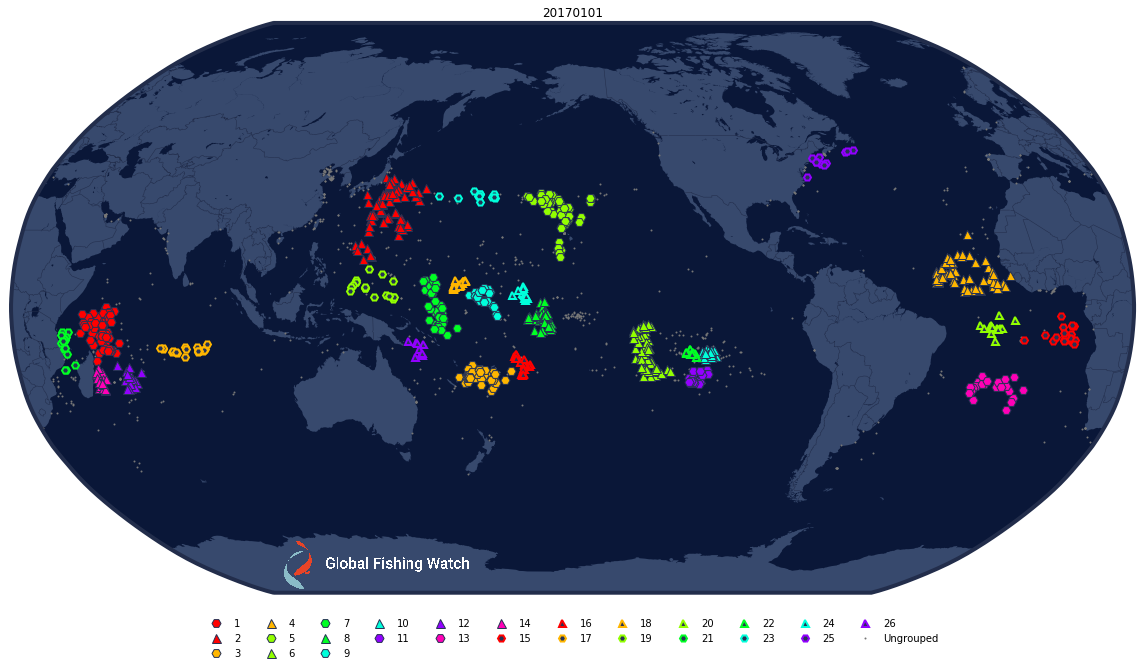

In [41]:
ssvid_20170101, labels_20170101 = find_labels(dists_by_date['20170101_daily'])
fleets_20170101 = create_fleet_mapping(labels_20170101)
all_by_date_20170101 = {k : v for (k, v) in all_by_date.items() if '20170101' <= k <= '20170101'}

animation.make_anim(ssvid_20170101, 
                           labels_20170101, 
                           all_by_date_20170101, 
                           interval=100,
                           fleets=fleets_20170101, 
                           show_ungrouped=True,
                           alpha=1,
                           legend_cols=12,
                           plot_frame=0,
                           text_color='black',
                           ungrouped_legend="Ungrouped")

24 fleets


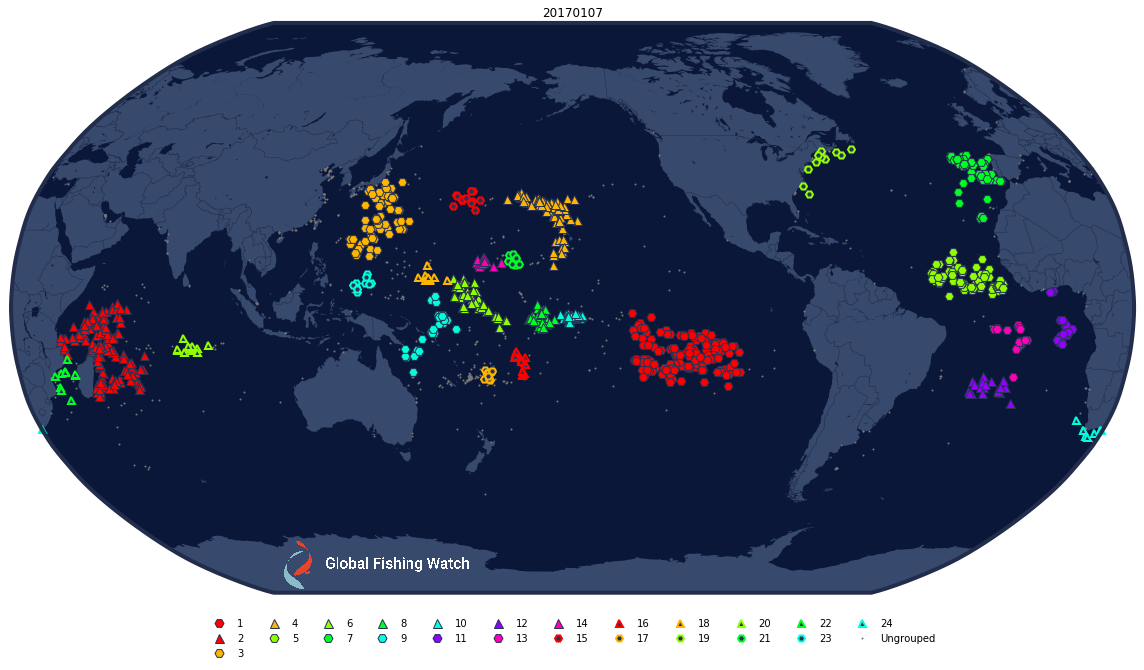

In [42]:
ssvid_20170107, labels_20170107 = find_labels(dists_by_date['20170107_daily'])
fleets_20170107 = create_fleet_mapping(labels_20170107)
all_by_date_20170107 = {k : v for (k, v) in all_by_date.items() if '20170107' <= k <= '20170107'}

animation.make_anim(ssvid_20170107, 
                           labels_20170107, 
                           all_by_date_20170107, 
                           interval=100,
                           fleets=fleets_20170107, 
                           show_ungrouped=True,
                           alpha=1,
                           legend_cols=12,
                           plot_frame=0,
                           text_color='black',
                           ungrouped_legend="Ungrouped")

# Clustering Across a Year

In [44]:
start_date = '20170101'
end_date = '20171231'
key = start_date
if key not in dists_by_date:
    print("computing distance for", start_date, end_date)
    subset_by_date = {k : v for (k, v) in pruned_by_date.items() if start_date <= k <= end_date}
    C = distances.create_composite_lonlat_array(subset_by_date, valid_ssvid)
    dists = distances.compute_distances_RMS(C)
    dists_by_date[key] = dists

computing distance for 20170101 20171231


In [45]:
raw_clusterers = {}
for key in ['20170101']:
    clusterer = hdbscan.HDBSCAN(metric='precomputed', 
                                min_cluster_size=9,
                               )
    dists = dists_by_date[key]
    clusterer.fit(dists)
    raw_clusterers[key] = clusterer

28 fleets


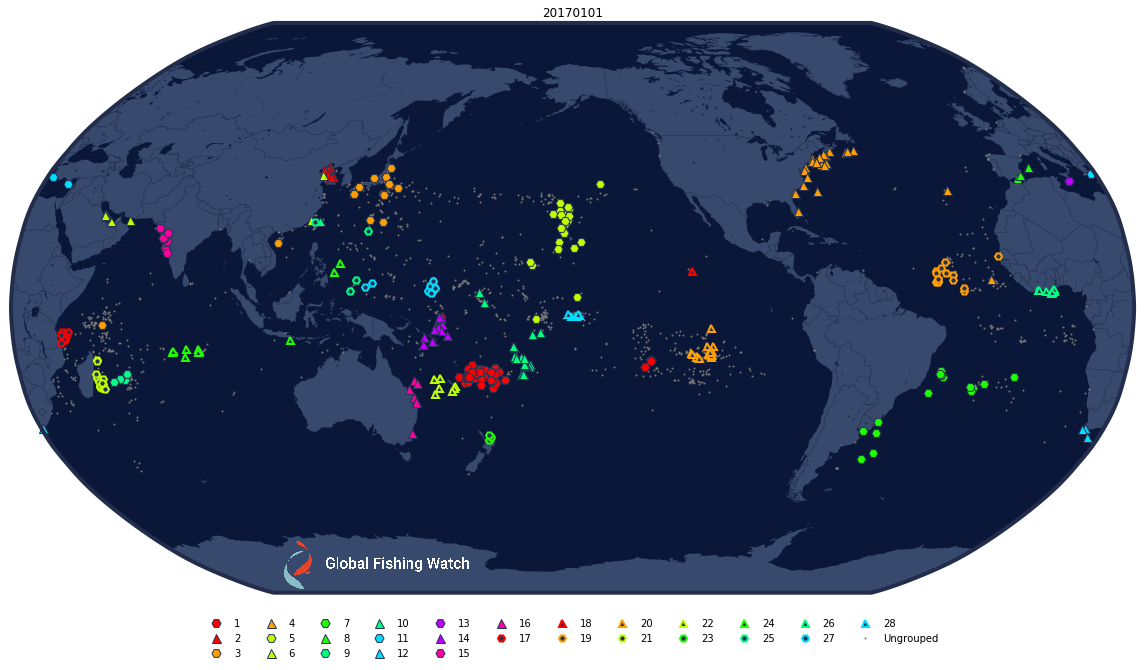

In [46]:
ssvid_2017, labels_2017 = find_labels(dists_by_date['20170101'])
fleets_2017 = create_fleet_mapping(labels_2017)

animation.make_anim(ssvid_2017, 
                           labels_2017, 
                           all_by_date_20170101, 
                           interval=100,
                           fleets=fleets_2017, 
                           show_ungrouped=True,
                           alpha=1,
                           legend_cols=12,
                           plot_frame=0,
                           text_color='black',
                           ungrouped_legend="Ungrouped")

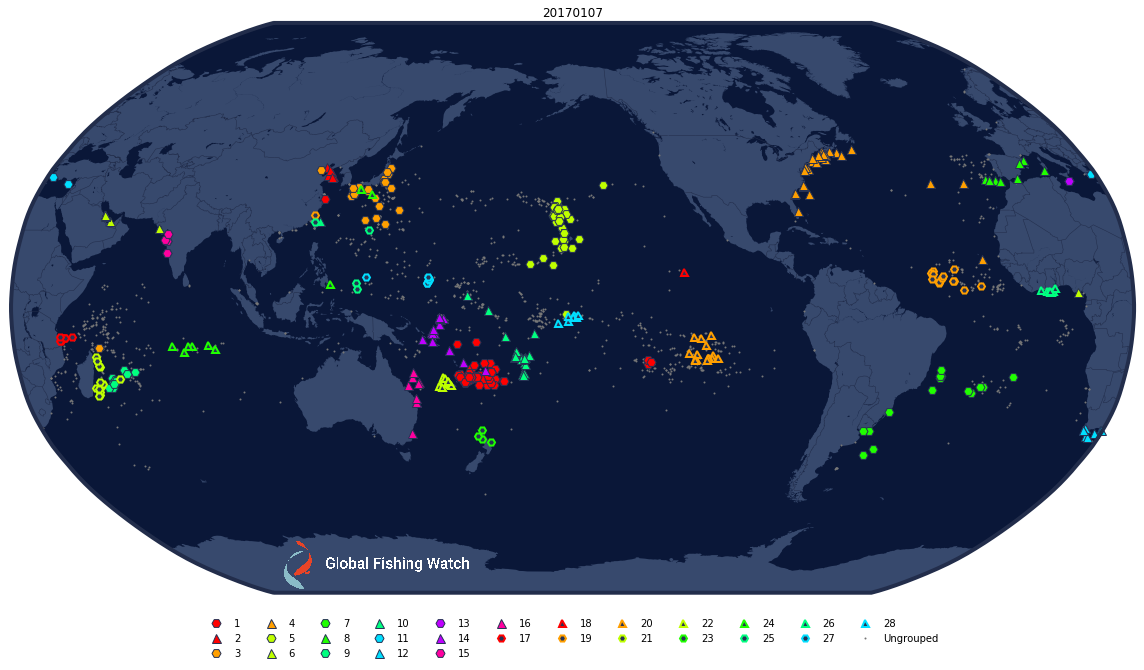

In [47]:
animation.make_anim(ssvid_2017, 
                           labels_2017, 
                           all_by_date_20170107, 
                           interval=100,
                           fleets=fleets_2017, 
                           show_ungrouped=True,
                           alpha=1,
                           legend_cols=12,
                           plot_frame=0,
                           text_color='black',
                           ungrouped_legend="Ungrouped")

# Tweaked Distance Matrix


In [61]:
start_date = '20170101'
end_date = '20171231'
key = start_date + '_tweaked'
if key not in dists_by_date:
    print("computing distance for", start_date, end_date)
    subset_by_date = {k : v for (k, v) in pruned_by_date.items() if start_date <= k <= end_date}
    C = distances.create_composite_lonlat_array(subset_by_date, valid_ssvid)
    dists = distances.compute_distances_tweaked(C)
    dists_by_date[key] = dists

computing distance for 20170101 20171231


In [62]:
raw_clusterers = {}
for key in ['20170101_tweaked']:
    clusterer = hdbscan.HDBSCAN(metric='precomputed', 
                                min_cluster_size=9,
                               )
    dists = dists_by_date[key]
    clusterer.fit(dists)
    raw_clusterers[key] = clusterer

39 fleets


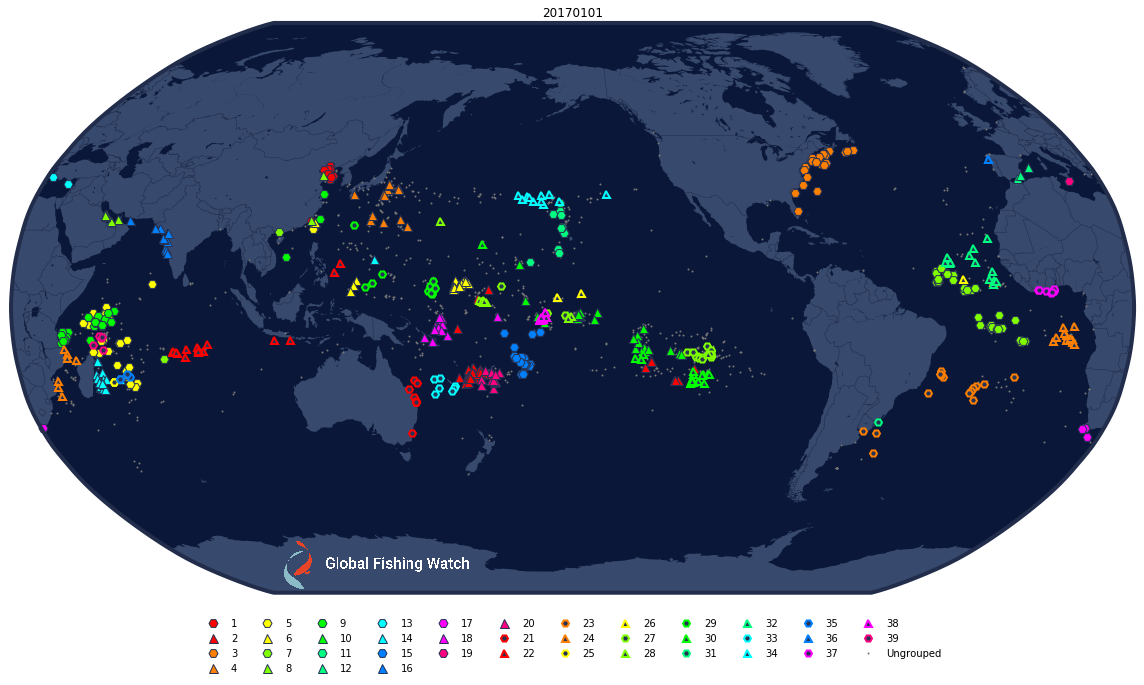

In [63]:
ssvid_2017_tweaked, labels_2017_tweaked = find_labels(dists_by_date['20170101_tweaked'])
fleets_2017_tweaked = create_fleet_mapping(labels_2017_tweaked)

animation.make_anim(ssvid_2017_tweaked, 
                           labels_2017_tweaked, 
                           all_by_date_20170101, 
                           interval=100,
                           fleets=fleets_2017_tweaked, 
                           show_ungrouped=True,
                           alpha=1,
                           legend_cols=12,
                           plot_frame=0,
                           text_color='black',
                           ungrouped_legend="Ungrouped")

39 fleets


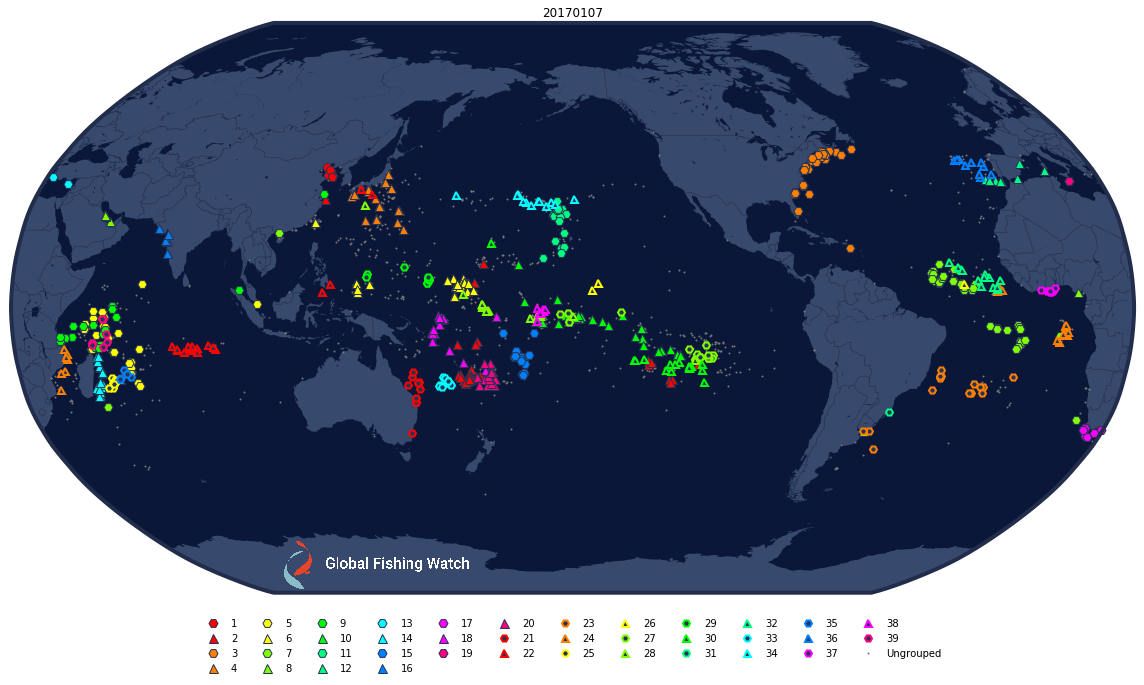

In [64]:
ssvid_2017_tweaked, labels_2017_tweaked = find_labels(dists_by_date['20170101_tweaked'])
fleets_2017_tweaked = create_fleet_mapping(labels_2017_tweaked)

animation.make_anim(ssvid_2017_tweaked, 
                           labels_2017_tweaked, 
                           all_by_date_20170107, 
                           interval=100,
                           fleets=fleets_2017_tweaked, 
                           show_ungrouped=True,
                           alpha=1,
                           legend_cols=12,
                           plot_frame=0,
                           text_color='black',
                           ungrouped_legend="Ungrouped")